# ---------------------------------------------
# CHALLENGE DESCRIPTION

Here attached a csv file containing a sample dataset consisting in (x, y) pairs on which you’ll have to perform a regression task.  

We ask you to work in a Jupyter notebook specifying the versions of Python (version 3.x please) and all libraries you use: when you’re done send us the notebook and we’ll execute it and check the results. As an alternative, you can also work in a script: just make sure the results from cross-validation are printed to screen when we execute it via the terminal, and that the plots get saved as files in png format in the same directory containing the script (send us a compressed archive with the script and the plots you produced).

To resume, here’s what you’ll need to do:

- (**yes**)     Open the file and read the data. 
- (**almost**)  Clean the data if needed. 
- (**yes**)     Plot the data. 
- (**yes**)     Fit two different regression models to the data (e.g. curves belonging to two different families).
- (**yes**)     Choose a metric for the evaluation of the models and perform the evaluation using cross-validation. 
- (**no**)      Plot the predictions from the best model against the data. 
- (**no**)      Specify python version and all the libraries used in the notebook 
- (**no**)      Make sure that all the plots are saved in "png" format in the same directory of the file 
- (**almost**)  Make sure that all the results from cross-validation are printed when executing the file via terminal! 
- (**no**)      Make sure that all gets executed on another computer and prepacked on compressed archives (script + plots!)

# ---------------------------------------------

# Analytics - Data Analytics Challenge Solution

## Outline of the notebook

1. Introduction: frame the problem
2. Retrieve and describe the dataset
3. Discover and visualize data for reacher insights 
4. Data cleaning (missing values)
5. Machine Learning Pipelines:
    - Model (1): Polynomial Regression Model
        1. Data prepocessing and model definition
        2. Model better evaluation using cross validation and fine-tuning model parameters using grid search
        3. Retrieve the best model parameters
    - Model (2): Ensemble Model (Gradient Boosting)
        1. Data preprocessing and model definition
        2. Model better evaluation using cross validation 
        3. Retrieve the best model parameters
6. Get the best model comparing metrics
7. Evaluate the system on the test set and plot the results
8. Conclusions

# (1) Introduction: frame the problem

**Description**: we are given a (csv) sample dataset consisting of (x, y) pairs on which we are required to perform a regression task. To be more specific, the assignment asks to: propose two different regression models, retrieve the best one through proper metric evaluation and comparison and use the latter to plot the predictions against the data.  


# (2) Retrieve and describe the dataset

In this section we will open and read the file in order to conduct a preliminary analysis. This is a fundamental step to get the first insights on how we should proceed when it comes to prepare the data before modeling.

[TODO: Questions]
- Would it be actually a good idea here to rescale/standardize/normalize the data in order to get better results? I guess here we would only benefit from rescaling in terms of speed of convergence of the algorithm, but I am not totally sure about this point!
- Handling missing values: I initially thought that, given the low percentage of missing in the data and the fact that there is already an evident trend (see plot below), it might be a good idea to drop them. However, consider this: what if we impute the data using a KNN imputer such that the missing observations gets closer to observations that have similar value. Would this procedure increase the risk of overfitting and might underestimate the presence of outliers? 

In [1]:
# Libraries needed for this section (and for the next ones)
import numpy as np
import pandas as pd

In [2]:
# Here we read and store the dataset
df = pd.read_csv("analytics_task_data.csv")

In [3]:
# Get the dimension of the dataset
df.shape

(500, 2)

We are dealing with a relative small dataset characterized by 500 observations and 2 features.

In [4]:
# Get the first few lines 
df.head()

,x,y
0,8.519119,48.073811
1,12.059918,302.657224
2,11.547357,247.531965
3,10.383055,127.686318
4,8.492261,55.086710


From the results above we can notice that the each observation is described by 2 numerical features. This gives further insights on what we are required to do: build regression models to predict the target variable "y" using "x", the explanatory variable. 

In [5]:
# Get statistics on the data 
df.describe()

,x,y
count,488.000000,462.000000
mean,9.767819,133.752630
std,1.614540,91.797160
min,7.007803,10.443932
25%,8.380894,59.919619
50%,9.781597,104.201239
75%,11.122550,194.316855
max,12.498972,375.943890


Having two numerical features, we wish to extract more information by presenting some statistics. [TODO: True?] The first thing we can notice here is that the two features have different mean and standard deviation, which might suggest that they are sampled from the same distribution with different parameters or that they simply belong to different distributions. In any case, these differences can be ignored for our purposes since we since they have little impact on our simple regression task outcomes. Indeed, such case would be relevant in case we had multiple predictors with different scales and we wished to estimate the target variable "y"

Most importantly, we can notice that both columns present missing values, but in different proportions with respect to the overall sample size. This fact requires further attention and needs special treatments when it comes to data preparation.

In [6]:
# Check presence of missing values 
if np.array(df.isnull().any()).any() == True: # TODO: 
    # store missing values information if any
    missing_data_sum = df.isnull().sum()
    # present results for each column
    print(f"""Number of missing values :

            x: {missing_data_sum.x} ({missing_data_sum.x/df.shape[0] * 100}% over total sample size) 
            y: {missing_data_sum.y} ({missing_data_sum.y/df.shape[0] * 100}% over total sample size) 
            overall: {missing_data_sum.x+missing_data_sum.y} ({(missing_data_sum.x+missing_data_sum.x)/df.shape[0] * 100}% over total sample size)
    """)

Number of missing values :

            x: 12 (2.4% over total sample size) 
            y: 38 (7.6% over total sample size) 
            overall: 50 (4.8% over total sample size)
    


Each column presents few missing values, and if they are considered jointly, the overall percentage of total cases with respect to the sample size remains below 5%. At this point, there are two plausible options available that could be adopted in order to take care of the presence of missing observations. Each of these will be further discussed and analyzed in the section relative to data cleaning procedures.


# (3) Discover and visualize data for reacher insights
Here we wish to dig a bit more into the characteristics of our sample through further analysis and data visualization techniques. Visualizing data is a fundamental step in order to deepen the relationship between the predictor(s) and the target variable. The aim of this section is then to uncover relationships that might not be as evident by only analyzing raw data.

In [7]:
# Libraries we need in this section (and in the coming ones as well)
import matplotlib.pyplot as plt
import seaborn as sns

# To get a much better experience when visualizing graphs
%matplotlib inline
sns.set(color_codes=True)

### Correlation analysis
Before proceeding with data visualization techniques, we wish to see how the two features are correlated to one another. In particular, the correlation analysis will give us evidence of the strength and direction of the linear relationship between two variables under scrutiny. Such assessment can be given by analyzing the correlation coefficient:

In [8]:
# Remove missings to calculate correlation coefficient (null values would drop the coefficient to 0)
df_corr = df.dropna(axis=0)
# Retrieve correlation coefficient
corr_coefs = np.corrcoef(df_corr.x.values,df_corr.y.values)
# Get correlation coefficient out there!
print(f"Correlation coefficient between 'x' and 'y' amounts to: {round(corr_coefs[0][1],2)}")

Correlation coefficient between 'x' and 'y' amounts to: 0.95


The correlation coefficient between the explanatory and the target variables results to be highly positive. This suggests us that, in most of the cases, increasing one variable would imply higher values also for the other considered variable, and viceversa. This number, along with a relatively high number of observations, is also signaling that the relationship might be modeled quite efficiently to predict future values. 

## Data visualization
Let's start with a simple scatter plot in order to see how the two features are related to each other and to look for evidence of what we saw through the correlation analysis 

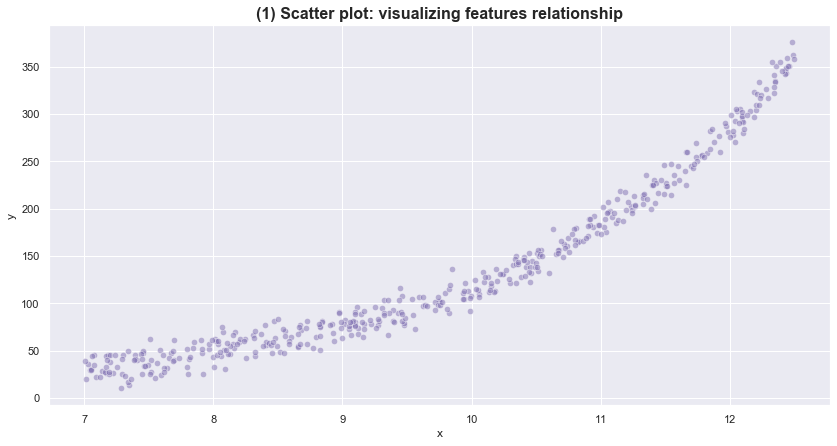

In [9]:
# First plot
plt.figure(figsize=(14,7))
plt.title("(1) Scatter plot: visualizing features relationship", fontsize=16, fontweight='bold')
scatter_plot = sns.scatterplot(x="x",y="y",data=df,s=40,color="m",alpha=0.50)

From the graph above we can notice that there is evidence of a strong relationship between the features. Furthermore, it seems from the graph that the relationship is non-linear. This would imply that, rather than sticking with a simple linear regression, we might need to add complexity in the model to better represent the trend highlighted here. If you are still not convinced, let's present further proofs using visualization techniques.

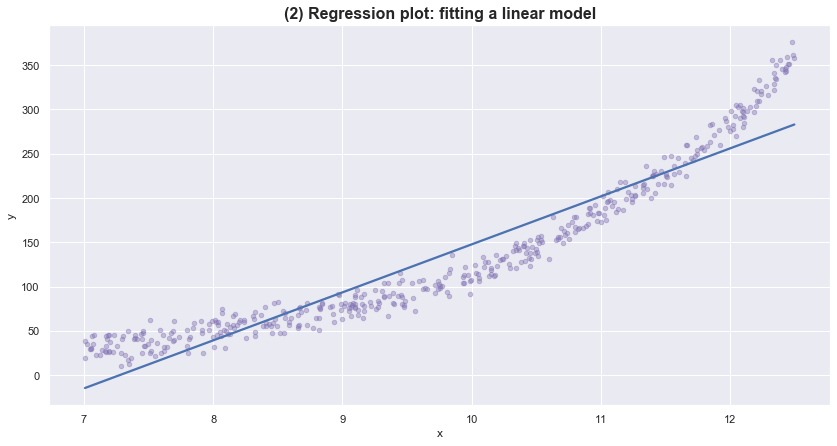

In [10]:
# Regression plot: scatter plot along with a fitted linear regression line 
plt.figure(figsize=(14,7))
plt.title("(2) Regression plot: fitting a linear model", fontsize=16, fontweight='bold')
reg_plot = sns.regplot(x="x", y="y", data=df, ci=None, scatter_kws={"s": 20, "color": "m","alpha": 0.40})

The graph above displays a scatter plot along with a fitted linear regression line. The model that presents this relationship may turn out to have a high score value (e.g. high R-Squared), but it would be relatively low given the trend highlighted before. Indeed, it would almost certainly underfit the data. In other words, if we fit a linear regression model with the data provided, there is high chance that it would be unable to accurately predict on unosberved data. As we already discussed before, in order to reach a better result, we could introduce complexity in the model. Let's see an example:

Text(0.5, 1, '(3) Regression plot: introducing non-linearity')

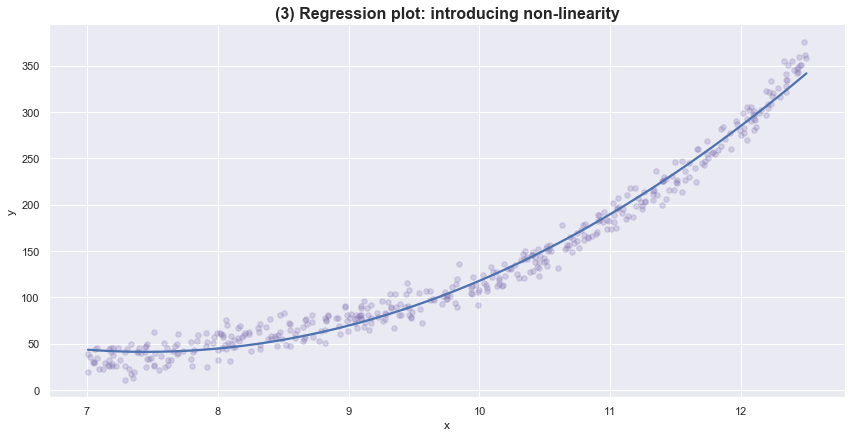

In [11]:
# Linear model plot with high-degree polynomial regression (degree=2)
reg_plot_non_lin = sns.lmplot(x="x", y="y", data=df, order=2, ci=None, height=6, aspect=2, scatter_kws={"s": 30, "color": "m", "alpha":0.25})
ax = plt.gca()
ax.set_title("(3) Regression plot: introducing non-linearity",fontsize=16,fontweight='bold')

The graph above still represents a scatter plot along with a regression plot, but this time we configured it in such a way that it tries to fit a polynomial regression model on the data. The only difference with respect to the previous graph is the regression equation: rather than being linear, now it is quadratic. This little difference seems to return a more accurate model in estimating the parameters to fit the line. 

One thing to notice here is that we set the order of the polynomial equation to 2. Configuring the model as such is enough to introduce non-linearity and complexity. However, from the graph it is clear that the line does not perfectly fit the data. Therefore, the question we wish to answer at this point is: can we do better than this by introducing additional complexity or by estimating using different models?

# (4) Data cleaning (Missing values)
In this section we wish to take care of issues that may arise from the data. In this particular case, we would only like to get rid of missing values and in order to do such, we will continue from the analysis we conducted above.

As we have just seen, both the explanatory and the dependent variables present cases of missing values that we need to take care of before proceeding. We have already seen that the overall percentage of missing values is below 5% with respect to the total sample size and, given the clear trend already highlighted by the rest of the sample, dropping these observations seems to be the best option. 

A question that may arise at this point is whether we could find a way to impute the data rather than just dropping them. 
Considering a simple imputer with either a mean or a median strategy to impute the values would not work properly here as it would tend to approximate values towards a single point with the consequence of introducing false information. Another approach we could consider is to impute them based on a K-Nearest-Neighbor imputer, which fits the data based on the characteristics of the K-th nearest observations and transform the missing data accordingly. On one hand, given the strong evidences of a clearly defined trend in the data, imputing the missing values would probably improve the model performances considerably, but on the other hand it might actually degenerate model predictive power due to additional assumptions on the structure of the data.

In [12]:
# Drop values
df.dropna(axis=0,subset=["x","y"], inplace=True)

# (5) Machine Learning Pipeline
In this section we will build two different regression model. We will first create a polynomial regression model and then we will see whether, by introducing an ensemble model, we can increase performance. To compute all the steps required to get the optimal model in a clear an nice fashion, we will make use of pipelines. One of the most important advantages of such approach is that you get a comprehensive object (the pipeline indeed) that can include data preprocessing, modeling, cross-validation and grid search procedures in one single object. Once defined, all you are required to do in order to get predictions, is to instantiate the pipeline and invoke the proper method on the test data. The latter will automatically trigger the same preprocessing that was performed on the training data and returns the predictions.  

In [13]:
# Libraries needed for modeling (and also for the coming ones)

# Transformers inheriting classes
from sklearn.base import BaseEstimator,TransformerMixin

# 1st model (Polynomial Regression Model)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# 2nd model (Ensemble Model: Gradient Boosting)
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

## Utilities
Here we introduce two utilities: the first one being a customized column transformer to pass to the pipeline in order to get the proper shape of the data for the regression task, while the second is a dictionary containing two different metrics that will be injected into the GridSearchCV object to be used during the cross validation procedure to better evaluate a model performance. 

**N.B**. Despite the presence of two different evaluation metrics, cross validation will perform evaluation only using one of the two metrics. The second metric is provided in order to get another point of view to evaluate model performances.

In [14]:
# Build a column transformer to reshape the data for the regression task. Such procedure can be directly injected to the pipeline
class ReshapeTransformer(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X.values.reshape(-1,1)

In [15]:
# Scoring metrics dictionary containing two different metrics to better evaluate model performances
scoring={
    "r2":"r2",
    "neg_mean_squared_error":"neg_mean_squared_error"
}

## (5.1) Model 1. Polynomial Regression Model
Here we define our first model: a polynomial regression model. In particular, we start by defining a range of possible polynomial degrees as a parameter that will be optimized in order to obtain the best performing model.

In [16]:
# Parameters for GridSearch in polynomial regression
param_grid_poly = {
    "polynomialfeatures__degree": range(2,31) # Define a range of possible polynomial degrees (from x**2 to x**30 [high-degree polynomial])
}

### (5.1.1) Data prepocessing and model definition
The following method declares the prepocessing and model objects that are passed as parameter to the pipeline (the returning object) 

In [17]:
# Pipeline for the polynomial regression model
def get_pipeline_poly():
    # Column reshaping transformer
    my_reshape_transformer = ReshapeTransformer()
    # Polynomial-degree transformer 
    my_poly_transformer = PolynomialFeatures()
    # Define the model
    my_poly_model = LinearRegression()
    # Define and return the pipeline: bundle together data preprocessing and model definition
    return make_pipeline(my_reshape_transformer, my_poly_transformer, my_poly_model)

### (5.1.2) Model better evaluation using cross validation and fine-tuning model parameters using grid search
The following method retrieve the pipeline and it passes it to the grid search object that will take care of optimizing the parameters while balancing between underfitting and overfitting  

In [18]:
# Retrieve the optimal polynomial regression model through GridSearchCV optimization procedure
def get_optimal_poly(x=df.x,y=df.y,param_grid=param_grid_poly):
    # Retrieve the pipeline for the polynomial model
    my_poly_pipeline = get_pipeline_poly()
    # Defines Grid Search with Cross Validation on the entire pipeline given a list of parameters in order to find those minimizing the scoring
    my_poly_optimal_model = GridSearchCV(my_poly_pipeline,param_grid,cv=5,scoring=scoring,refit="neg_mean_squared_error",verbose=0)
    # Fits the data and finds the best parameters according to GridSearchCV
    my_poly_optimal_model.fit(x,y)
    # Return the best parameters 
    return my_poly_optimal_model

### (5.1.3) Retrieve the best model
Here we istantiate the best polynomial model and we print optimality results 

In [19]:
my_poly_optimal = get_optimal_poly()

In [20]:
# Get the optimal degree for polynomial regression equation
optimal_degree = my_poly_optimal.best_params_["polynomialfeatures__degree"]
# Print the optimal degree for polynomial features 
print(f"The optimal degree for polynomial features in the polynomial regression model is: {optimal_degree}")

The optimal degree for polynomial features in the polynomial regression model is: 6


In [21]:
# Print both metrics!
poly_metrics = my_poly_optimal.cv_results_
# RMSE (Root Mean Squared Error)
print(f"Best polynomial regression model MSE: {(-1)*max(poly_metrics['mean_test_neg_mean_squared_error'])}")
# R2 (R-Squared)
print(f"Best polynomial regression model R2: {max(poly_metrics['mean_test_r2'])}")

Best polynomial regression model MSE: 100.86249894734247
Best polynomial regression model R2: 0.9874398493694626


## (5.2) Model 2. Ensemble Model (Gradient Boosting)

In [22]:
# Parameter grid containing the possible parameters values to be optimized through GridSearchCV. Each parameter will be passed through the pipeline and will be assigned where it belongs. The standard parameter name is: "pipeline_object_name__parameter"
param_grid_ensemble = {
    "polynomialfeatures__degree": [6], # already optimized in the previous model
    "xgbregressor__objective": ["reg:squarederror"], 
    "xgbregressor__booster": ["gblinear"], # change GLM (Generalized Least Square) rather than tree-based learners
    "xgbregressor__learning_rate": [0.2, 0.1, 0.05, 0.01], # percentage of contribution of each new base learner 
    "xgbregressor__n_estimators": [500,750,1000], # number of base learners iteratively trained
    "xgbregressor__early_stopping_rounds": [5], # rounds of straight deterioration allowed before stopping
}

### (5.1.1) Data prepocessing and model definition

In [25]:
def get_ensemble_pipeline():
    # Column reshaping transformer
    my_reshape_transformer = ReshapeTransformer()
    # MinMaxScaler on columns
    my_minmax_scaler = StandardScaler() # TODO Might be a good idea here to rescale the data to increase gradient descending performance !
    # Get the proper polynomial features in the data
    my_poly_transformer = PolynomialFeatures()
    # Model
    my_ensemble_model = XGBRegressor()
    # Define and return the Pipeline
    return make_pipeline(my_reshape_transformer,my_minmax_scaler,my_poly_transformer,my_ensemble_model)

### (5.1.2) Model better evaluation using cross validation and fine-tuning model parameters using grid search

In [26]:
# Retrieve the optimal GradientBoosting model to perform predictions
def get_optimal_ensemble(x=df.x,y=df.y,param_grid=param_grid_ensemble):
    # Retrieve the pipeline for the Gradient Boosting model
    my_pipeline = get_ensemble_pipeline()
    # Defines Grid Search with Cross Validation on the entire pipeline given a list of parameters in order to find those minimizing the scoring
    my_ensemble_model = GridSearchCV(my_pipeline,param_grid,cv=5,scoring=scoring,refit="neg_mean_squared_error",verbose=0)
    # Fits the data and finds the best parameters according to GridSearchCV
    my_ensemble_model.fit(x,y)
    # Return the best parameters 
    return my_ensemble_model

### (5.1.3) Retrieve the best model

In [27]:
# Retrieve the optimal ensemble model
my_ensemble_optimal = get_optimal_ensemble()

In [28]:
# Print both metrics!
ensemble_metrics = my_ensemble_optimal.cv_results_
# RMSE (Root Mean Squared Error)
print(f"Best ensemble model MSE: {(-1)*max(ensemble_metrics['mean_test_neg_mean_squared_error'])}")
# R2 (R-Squared)
print(f"Best ensemble model R2: {max(ensemble_metrics['mean_test_r2'])}")

Best ensemble model MSE: 103.37461724233592
Best ensemble model R2: 0.9872617026908952


# (6) Get the best model comparing metrics
Here we wish to obtain the best performing model between the two proposed above by comparing their evaluation metrics

In [29]:
# Check which model has the lowest averaged mean squared error (MSE) on test set

# Retrieve the best scores from both models (multiplied by (-1) due to negative valued metrics)
best_score_poly = (-1)*my_poly_optimal.best_score_
best_score_ensemble = (-1)*my_ensemble_optimal.best_score_

# Retrieve and store the optimal model
if best_score_poly < best_score_ensemble:
    print(f"The best performing model is Polynomial Regression Model with a MSE of: {best_score_poly}")
    my_best_model = my_poly_optimal
else:
    print(f"The best performing model is Polynomial Regression Model with a MSE of: {best_score_ensemble}")
    my_best_model = my_ensemble_optimal

The best performing model is Polynomial Regression Model with a MSE of: 100.86249894734247


# (7) Evaluate the system on a test set and plot the results
Here we plot the predictions from out best model against the true observations

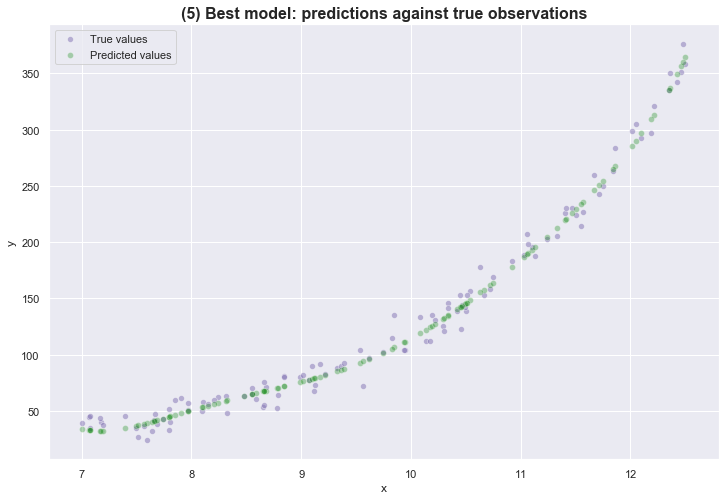

In [52]:
# Divide data into train-test
x_train_best,x_test_best,y_train_best,y_test_best = train_test_split(df.x,df.y)

# Target prediction using the best model
y_preds_best = my_best_model.predict(x_test_best)

# PLOT
# (1) Configure graph
plt.figure(figsize=(12,8))
plt.title("(5) Best model: predictions against true observations",fontsize=16,fontweight='bold')
# (2) True data
sns.scatterplot(x=x_test_best, y=y_test_best, color='m', alpha=0.5, label="True values")
# (3) Best model predictions
sns.scatterplot(x=x_test_best, y=y_preds_best, color='green', alpha=0.3, label="Predicted values")
# (4) Save the graph
plt.savefig("5_true_preds_plot.png",dpi=300)

# (8) Conclusions

# (Bonus) Additional content 

# [TODO] Script: save ALL the plots!

In [51]:
# Save all the produced plots
scatter_plot.figure.savefig("1_scatter_plot.png",dpi=300)
reg_plot.figure.savefig("2_regression_plot.png",dpi=300)
reg_plot_non_lin.savefig("3_regression_plot_non_lin.png",dpi=300)
# + xgboost param opt
